In [2]:
!pip install datasets gensim

In [3]:
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset
from collections import Counter
import gensim.downloader as api
import numpy as np
import os
import json
import torch
import torch.nn as nn
import torch.functional as F
import json
from tqdm.auto import tqdm
import sys


/home/bach/anaconda3/envs/ntu_nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading dataset and data processing

In [4]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [5]:
word2vec_model = api.load('glove-wiki-gigaword-100')
embeddings = word2vec_model.vectors
w2v_vocab = word2vec_model.key_to_index

In [6]:
len(w2v_vocab)

400000

In [7]:
w2v_vocab['<UNK>'] = 400000
w2v_vocab['<PAD>'] = 400001

In [8]:
avg_vec = np.mean(embeddings, axis=0)

In [9]:
avg_vec

array([ 0.05209883, -0.09711445, -0.1380765 ,  0.11075345, -0.02722748,
       -0.00326409,  0.03176443, -0.05076874,  0.15321693, -0.02367382,
       -0.0078552 ,  0.08436131, -0.08042031, -0.08836847, -0.01713637,
        0.07352565, -0.16472325,  0.05473585,  0.15367231, -0.05284015,
       -0.16474274, -0.00894895, -0.13604094, -0.03889371, -0.09204532,
        0.02874651,  0.02445944,  0.19419461, -0.03297978,  0.00509352,
        0.0146906 , -0.1554301 ,  0.03542742, -0.02936257,  0.01372886,
       -0.0606757 ,  0.02025392, -0.14560148,  0.05823914,  0.01729455,
        0.16282158,  0.18634756, -0.06337869,  0.1306742 , -0.11122588,
        0.0272168 ,  0.03868013,  0.15675613,  0.01344932,  0.1942456 ,
       -0.01218801,  0.03659216, -0.08235365, -0.24420363,  0.07523726,
        0.46423653,  0.06318451,  0.0508127 , -0.38147202, -0.20739552,
        0.03489431, -0.18234783,  0.09021272, -0.02504168, -0.22256528,
        0.03382994, -0.13379364, -0.14375682, -0.11264054, -0.03

In [10]:
embeddings[-1]

array([ 0.28365  , -0.6263   , -0.44351  ,  0.2177   , -0.087421 ,
       -0.17062  ,  0.29266  , -0.024899 ,  0.26414  , -0.17023  ,
        0.25817  ,  0.097484 , -0.33103  , -0.43859  ,  0.0095799,
        0.095624 , -0.17777  ,  0.38886  ,  0.27151  ,  0.14742  ,
       -0.43973  , -0.26588  , -0.024271 ,  0.27186  , -0.36761  ,
       -0.24827  , -0.20815  ,  0.22128  , -0.044409 ,  0.021373 ,
        0.24594  ,  0.26143  ,  0.29303  ,  0.13281  ,  0.082232 ,
       -0.12869  ,  0.1622   , -0.22567  , -0.060348 ,  0.28703  ,
        0.11381  ,  0.34839  ,  0.3419   ,  0.36996  , -0.13592  ,
        0.0062694,  0.080317 ,  0.0036251,  0.43093  ,  0.01882  ,
        0.31008  ,  0.16722  ,  0.074112 , -0.37745  ,  0.47363  ,
        0.41284  ,  0.24471  ,  0.075965 , -0.51725  , -0.49481  ,
        0.526    , -0.074645 ,  0.41434  , -0.1956   , -0.16544  ,
       -0.045649 , -0.40153  , -0.13136  , -0.4672   ,  0.18825  ,
        0.2612   ,  0.16854  ,  0.22615  ,  0.62992  , -0.1288

In [11]:
embeddings = np.append(embeddings, [avg_vec], axis=0)
embeddings = np.append(embeddings, [np.zeros_like(embeddings[-1])], axis=0)

## Tokenizing

1. We ignore the words
2. We map them to `UNK`, available in word2vec vocab

In [12]:
def tokenize(vocab, text):
    """Tokenize a given text using NLTK, returning the corresponding in our pretrained embeddings"""
    tokens = word_tokenize(text.lower())  # Tokenize the text into words
    token_ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]  # Get token IDs
    return {"tokens": tokens, "ids": token_ids}

In [13]:
nltk.download('punkt')

class NLTKTokenizer:
    def __init__(self, config=None):
        self.vocab = {'<UNK>': 400000, '<PAD>': 400001}
        self.config = config or {}
        self.pad_id = None  # Store pad_id for future use

    @classmethod
    def from_pretrained(cls, vocab):
        """Load a tokenizer with a pre-built vocabulary from a saved file."""
        tokenizer = cls()
        tokenizer.vocab = vocab
        tokenizer.pad_id = vocab.get("<PAD>", 1)  # Ensure pad_id is set
        return tokenizer

    def build_vocab(self):
        """Build vocabulary from the given dataset."""
        from collections import Counter
        from datasets import load_dataset

        dataset = load_dataset(self.config["dataset"])
        train_dataset = dataset['train']
        vocab = Counter(self.vocab)
        for item in train_dataset:
            tokens = word_tokenize(item['text'].lower())
            vocab.update(tokens)
        self.vocab = {word: idx for idx, (word, _) in enumerate(vocab.items(), 1)}  # Index starts at 1
        #print(self.vocab)

    def tokenize(self, text):
        """Tokenize a given text using NLTK."""
        tokens = word_tokenize(text.lower())  # Tokenize the text into words
        token_ids = [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]  # Get token IDs
        # token_ids = [self.vocab.get(token, np.zeros_like(self.vocab['UNK'])) for token in tokens]  # Get token IDs

        return {"tokens": tokens, "ids": token_ids}

    def save(self, folder_path):
        """Save the vocabulary to a file."""
        os.makedirs(folder_path, exist_ok=True)
        with open(os.path.join(folder_path, "vocab.json"), "w") as f:
            json.dump(self.vocab, f)

[nltk_data] Downloading package punkt to /home/bach/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
tokenizer = NLTKTokenizer.from_pretrained(w2v_vocab)

## Dataloader

In [15]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [16]:
class ClassificationDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        text = item["text"]
        label = item["label"]
        ids = self.tokenizer.tokenize(text)["ids"]
        length = len(ids)
        ids = torch.tensor(ids)
        return ids, length, label

In [17]:
def get_dataloaders(
    tokenizer,
    dataset,
    training_bs,
    val_bs,
):
    train_dataset = ClassificationDataset(dataset["train"], tokenizer)
    validation_dataset = ClassificationDataset(dataset["validation"], tokenizer)
    test_dataset = ClassificationDataset(dataset["test"], tokenizer)
    # partial function to be used in DataLoader
    def padding_fn(batch):
        # pad sequences in the same batch to be the same shape
        (xx, lengths, yy) = zip(*batch)
        xx_pad = pad_sequence(xx, batch_first=True, padding_value=tokenizer.pad_id)
        return xx_pad, torch.tensor(lengths), torch.tensor(yy)
    train_loader = DataLoader(train_dataset, batch_size=training_bs, shuffle=True, collate_fn=padding_fn)
    val_loader   = DataLoader(validation_dataset, batch_size=val_bs, shuffle=True, collate_fn=padding_fn)
    test_loader  = DataLoader(test_dataset, batch_size=val_bs, shuffle=True, collate_fn=padding_fn)

    return train_loader, val_loader, test_loader

In [18]:
train_loader, val_loader, test_loader = get_dataloaders(
    tokenizer=tokenizer,
    dataset=dataset,
    training_bs=32,
    val_bs=32,
)

# Initializing the model

In [19]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [84]:
class RNNLayer(nn.Module):
    def __init__(self, dim_input, dim_hidden, direction=1):
        super(RNNLayer, self).__init__()
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden

        self.i2h = nn.Linear(dim_input + dim_hidden, dim_hidden)
        self.i2o = nn.Linear(dim_input + dim_hidden, dim_hidden)
        self.direction = direction

    def forward(self, input, hidden):
        outputs = []
        if self.direction == 1:
            for i in range(input.size()[1]):
                combined = torch.cat((input[:, i, :], hidden), dim=1)
                hidden = self.i2h(combined)
                output_cell = self.i2o(combined)
                outputs.append(output_cell)
        else: 
            for i in range(input.size()[1]-1, -1, -1):
                combined = torch.cat((input[:, i, :], hidden), dim=1)
                hidden = self.i2h(combined)
                output_cell = self.i2o(combined)
                outputs.append(output_cell)
        return torch.stack(outputs, dim=1) # (batch_size, seq_len, dim_hidden)

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.dim_hidden)

class DeepRNN(nn.Module):
    def __init__(self, dim_input, dim_hidden, num_layers, direction=1):
        super(DeepRNN, self).__init__()
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        self.num_layers = num_layers
        self.direction = direction
        
        self.input_layer = RNNLayer(dim_input, dim_hidden, direction=direction)
        self.rnn_layers = nn.ModuleList([RNNLayer(dim_hidden, dim_hidden, direction=direction) for _ in range(num_layers)])
    
    def forward(self, input):
        hidden = self.input_layer.init_hidden(input.size()[0])
        outputs = self.input_layer(input, hidden)
        for i in range(self.num_layers):
            hidden = self.rnn_layers[i].init_hidden(input.size()[0])
            outputs = self.rnn_layers[i](outputs, hidden)
        return outputs

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.dim_hidden)

class BiDeepRNN(nn.Module):
    def __init__(self, vocab_size, dim_input, dim_hidden, dim_output, num_layers, pretrained_embeddings=None, freeze_embeddings=False):
        
        super(BiDeepRNN, self).__init__()

        if pretrained_embeddings is not None:
                print("Loading pretrained word embeddings")
                self.token_embedding = nn.Embedding.from_pretrained(
                    torch.tensor(pretrained_embeddings, dtype=torch.float),
                    freeze=freeze_embeddings
                )
        else:
            self.token_embedding = nn.Embedding(vocab_size, dim_input)
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        self.dim_output = dim_output
        self.num_layers = num_layers

        self.rnn_layers_forward = DeepRNN(dim_input, dim_hidden, num_layers, direction=1)
        self.rnn_layers_backward = DeepRNN(dim_input, dim_hidden, num_layers, direction=-1)
        self.output_layer = nn.Linear(2*dim_hidden, dim_output)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input):
        # Since we are dealing with Char-RNN task so we dont need to use all the output
        embeddings = self.token_embedding(input)

        fs = self.rnn_layers_forward(embeddings)
        bs = self.rnn_layers_backward(embeddings)
        outputs = torch.cat((fs, torch.flip(bs, dims=(1,))), dim=-1)    
        # outputs : (batch_size, seq_len, 2*dim_hidden)
        outputs = self.output_layer(outputs)
        outputs = self.softmax(outputs)
        return outputs

In [85]:
len(w2v_vocab)

400002

In [86]:
vocab_size=len(w2v_vocab)
dim_input = embeddings[0].shape[0]
dim_hidden = 256

In [87]:
dim_input

100

# Training loop

Use the pretrained word embeddings from Part 1 as inputs; do not update them during training (they are “frozen”).

Design a simple recurrent neural network (RNN), taking the input word embeddings, and predicting a sentiment label for each sentence. To do that, you need to consider how to aggregate the word representations to represent a sentence.

Use the validation set to gauge the performance of the model for each epoch during training. You are required to use accuracy  as the performance metric during validation and evaluation.

Use the mini-batch strategy during training.  You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You should use the validation set to determine the optimal configuration.) Train the model until the accuracy  score on the validation set is not increasing for a few epochs.

Evaluate your trained model on the test dataset, observing the accuracy score.

In [88]:
model = BiDeepRNN(vocab_size=len(w2v_vocab),
            dim_input=dim_input,
            dim_hidden=dim_hidden,
            num_layers=3,
            dim_output=2,
            pretrained_embeddings=embeddings,
            freeze_embeddings=True)

Loading pretrained word embeddings


In [89]:
learning_rate = 1e-4
num_epochs = 100
metric_log_interval = 1
num_stopping_rounds = 10
loss_fn = nn.BCELoss()
training_bs = 32

In [90]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

In [91]:
model.train()
train_loss = 0
data_iter = iter(train_loader)

In [92]:
class EarlyStopper:
    def __init__(self, patience=50, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [93]:
early_stopper = EarlyStopper(patience=num_stopping_rounds,
                             min_delta=0)
train_loss = []
val_loss = []
metrics = []
for step_id in tqdm(range(num_epochs)):

    epoch_loss = []
    for i, (input, length, label) in tqdm(enumerate(train_loader)):

        input, length, label = input.to(device), length.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(input)
        output = output[range(input.size()[0]), length - 1]
        one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float).to(device)
        loss = loss_fn(output, one_hot_label)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item() / training_bs)

        output_label = torch.argmax(output, axis=1)

    train_loss.append(sum(epoch_loss) / len(epoch_loss))

    epoch_loss = []
    epoch_acc = []
    with torch.no_grad():
        for i, (input, length, label) in enumerate(val_loader):
            input, length, label = input.to(device), length.to(device), label.to(device)

            output = model(input)
            output = output[range(input.size()[0]), length - 1]
            one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float32).to(device)

            loss = loss_fn(output, one_hot_label)
            epoch_loss.append(loss.item() / training_bs)

            output_label = torch.argmax(output, axis=1)
            epoch_acc.append((output_label == label).sum() / len(label))

    epoch_loss_ = sum(epoch_loss) / len(epoch_loss)
    val_loss.append(epoch_loss_)
    metrics.append(sum(epoch_acc) / len(epoch_acc))
    print(
            f"""Step {step_id + 1}:
                Train Loss: {train_loss[-1]},
                Val_loss: {val_loss[-1]},
                Accuracy:{metrics[-1]}"""
    )
    if early_stopper.early_stop(epoch_loss_):
        print('Early Stopping model training')
        break

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_115852/2759680990.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float).to(device)
267it [01:32,  2.89it/s]
/tmp/ipykernel_115852/2759680990.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float32).to(device)
  1%|          | 1/100 [01:35<2:37:02, 95.18s/it]

Step 1:
                Train Loss: 0.019615536660290835,
                Val_loss: 0.01802966497181093,
                Accuracy:0.7115808725357056


267it [01:20,  3.34it/s]
  2%|▏         | 2/100 [02:57<2:23:27, 87.83s/it]

Step 2:
                Train Loss: 0.01759707342749566,
                Val_loss: 0.017461559379144627,
                Accuracy:0.7266544103622437


267it [01:18,  3.38it/s]
  3%|▎         | 3/100 [04:19<2:17:22, 84.97s/it]

Step 3:
                Train Loss: 0.017294559195247035,
                Val_loss: 0.017698344089748227,
                Accuracy:0.7248161435127258


267it [01:22,  3.24it/s]
  4%|▍         | 4/100 [05:44<2:15:57, 84.97s/it]

Step 4:
                Train Loss: 0.01712638084263949,
                Val_loss: 0.017161613220677656,
                Accuracy:0.7284926176071167


267it [01:19,  3.37it/s]
  5%|▌         | 5/100 [07:06<2:12:48, 83.88s/it]

Step 5:
                Train Loss: 0.016904873438598065,
                Val_loss: 0.017312848885707995,
                Accuracy:0.7123161554336548


267it [01:19,  3.35it/s]
  6%|▌         | 6/100 [08:30<2:11:24, 83.88s/it]

Step 6:
                Train Loss: 0.01659099300032698,
                Val_loss: 0.01698923557448913,
                Accuracy:0.721139669418335


267it [01:20,  3.31it/s]
  7%|▋         | 7/100 [09:53<2:09:45, 83.72s/it]

Step 7:
                Train Loss: 0.016328455705879333,
                Val_loss: 0.017618281657204908,
                Accuracy:0.7086396813392639


267it [01:18,  3.39it/s]
  8%|▊         | 8/100 [11:15<2:07:14, 82.98s/it]

Step 8:
                Train Loss: 0.016426085424696684,
                Val_loss: 0.0176856476430069,
                Accuracy:0.7033088207244873


267it [01:23,  3.21it/s]
  9%|▉         | 9/100 [12:40<2:07:05, 83.80s/it]

Step 9:
                Train Loss: 0.016250655355022642,
                Val_loss: 0.017284939805155292,
                Accuracy:0.7215073704719543


267it [01:19,  3.36it/s]
 10%|█         | 10/100 [14:02<2:04:57, 83.30s/it]

Step 10:
                Train Loss: 0.01597839244728566,
                Val_loss: 0.017313921221477145,
                Accuracy:0.7108455896377563


267it [01:18,  3.40it/s]
 11%|█         | 11/100 [15:24<2:02:43, 82.73s/it]

Step 11:
                Train Loss: 0.016026352476398373,
                Val_loss: 0.01808912230326849,
                Accuracy:0.703125


267it [01:17,  3.46it/s]
 12%|█▏        | 12/100 [16:43<1:59:57, 81.79s/it]

Step 12:
                Train Loss: 0.01581931233838591,
                Val_loss: 0.017599551609772092,
                Accuracy:0.7040441036224365


267it [01:17,  3.44it/s]
 13%|█▎        | 13/100 [18:05<1:58:34, 81.77s/it]

Step 13:
                Train Loss: 0.015844944163403485,
                Val_loss: 0.018057767164838666,
                Accuracy:0.699999988079071


267it [01:17,  3.42it/s]
 14%|█▍        | 14/100 [19:26<1:56:40, 81.40s/it]

Step 14:
                Train Loss: 0.015717806559655996,
                Val_loss: 0.018006925498518872,
                Accuracy:0.721139669418335


267it [01:16,  3.47it/s]
 15%|█▌        | 15/100 [20:45<1:54:31, 80.84s/it]

Step 15:
                Train Loss: 0.015593305610343534,
                Val_loss: 0.017544903408955124,
                Accuracy:0.7090073823928833


267it [01:20,  3.32it/s]
 15%|█▌        | 15/100 [22:08<2:05:28, 88.57s/it]

Step 16:
                Train Loss: 0.015545514994736914,
                Val_loss: 0.01807397828601739,
                Accuracy:0.6988970637321472
Early Stopping model training


In [95]:
import matplotlib.pyplot as plt

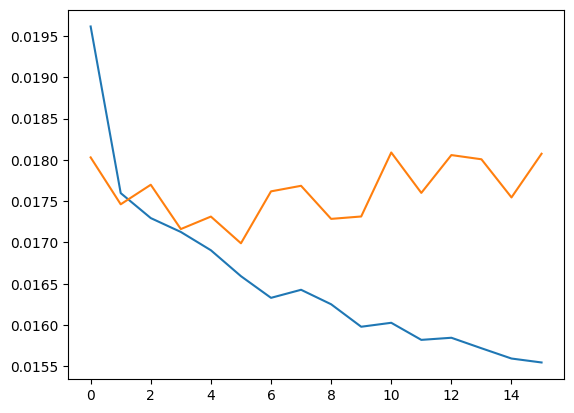

In [96]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

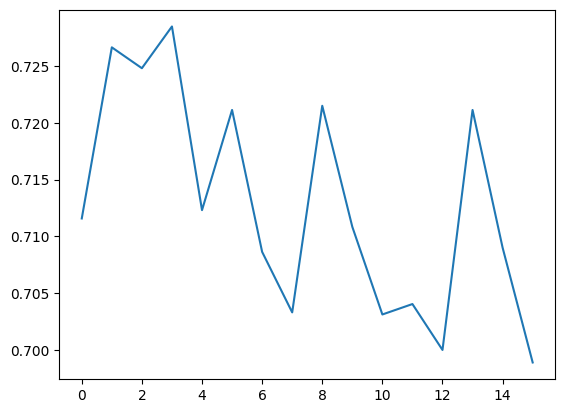

In [97]:
plt.plot(metrics)

# Evaluation

In [100]:
test_acc = []

for i, (input, length, label) in enumerate(test_loader):
    input, length, label = input.to(device), length.to(device), label.to(device)
    output = model(input)
    output = output[range(input.size()[0]), length - 1]
    one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float32).to(device)

    output_label = torch.argmax(output, axis=1)
    test_acc.append((output_label == label).sum())

/tmp/ipykernel_115852/3510043425.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float32).to(device)


In [101]:
sum(test_acc) / len(test_dataset)

tensor(0.7083)